In [923]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

In [924]:
# Generates a new population
# pop_num - the size of the population
def generate_pop(pop_num):
  population = []

  for _ in range(0, pop_num):
    individual = [random.random() * 5, random.random() * -5, random.random() * -5, random.random() * -5]
    population.append(individual)

  return population

In [925]:
def blx_alpha(x1, x2, alpha=0.5):
    c_min = min(x1, x2)
    c_max = max(x1, x2)
    I = c_max - c_min
    return random.uniform(c_min - alpha*I, c_max + alpha*I)

# crossover with 2 parents
def crossover(parent1, parent2, prob=0.7, alpha=0.5):
    # No crossover
    if random.random() > prob:
        return parent1, parent2
    
    # Generate children using BLX-alpha
    child1 = [blx_alpha(x1, x2, alpha) for x1, x2 in zip(parent1, parent2)]
    child2 = [blx_alpha(x1, x2, alpha) for x1, x2 in zip(parent1, parent2)]
    
    return child1, child2

In [926]:
# mutation on one individual
def mutation(individual, prob=0.01):
  if (random.random() > prob):
    return individual

  random_param = random.randint(0, 3)
  individual[random_param] = random.random() * 5 if random_param == 0 else random.random() * -5

  return individual

In [927]:
class Driver:
    def __init__(self, location, rest_time, x, y, z, w):
        self.location = location
        self.rest_time = rest_time
        self.x = x
        self.y = y
        self.z = z
        self.w = w

class Request:
    def __init__(self, start_time, duration, distance, money, 
                 start_latitude, start_longitude, end_latitude, end_longitude):
        self.start_time = start_time
        self.duration = duration
        self.distance = distance
        self.money = money
        self.start_latitude = start_latitude
        self.start_longitude = start_longitude
        self.end_latitude = end_latitude
        self.end_longitude = end_longitude

In [ ]:
point = (0,0) # center of requests

def distance_measure(point1, point2):
  return math.sqrt((point1[0]-point2[0]) ** 2 + (point1[1]-point2[1]) ** 2)

def get_score(driver, request):
    return driver.x*request.money + driver.y*request.duration + \
    driver.z*distance_measure((driver.location["lat"], driver.location["lng"]), (request.start_latitude, request.start_longitude)) + \
    driver.w*distance_measure((request.end_latitude, request.end_longitude), point)

# def get_best(driver, requests, cur_ind, nxt_ind):

#   best_score = get_score(driver, requests[cur_ind])
#   best_ind = cur_ind
#   for i in range(cur_ind+1, nxt_ind):
#     cur_score = get_score(driver, requests[i])
#     if(cur_score > best_score):
#       best_ind = i

#   return best_ind

x = 10
# computes the money gained by the driver for the expected requests
def iteration(population, requests):
  money = 0
  current_time = 0
  driver = Driver({"lat": 0, "lng": 0}, 0, population[0], population[1], population[2], population[3])
  for i in range(0, len(requests)):
    if (requests[i].start_time < current_time):
      continue

    request_score = get_score(driver, requests[i])
    if (request_score > x):
      current_time = requests[i].start_time + requests[i].duration
      driver.location["lat"] = requests[i].end_latitude
      driver.location["lng"] = requests[i].end_longitude
      money += requests[i].money

  return money

In [929]:
# finds optimal parameters
# takes requests throughtout the day and number of iterations
def train(requests, iter=100):
  population = generate_pop(1000)
  best_earnings = []
  average_earnings = []

  best_one = population[0]
  for _ in range(0, iter):
    earnings = []
    earnings_sum = 0
    for i in range(0, len(population)):
      earning = iteration(population[i], requests)
      earnings_sum += np.exp(earning)
      earnings.append(earning)

    best_index = earnings.index(max(earnings))
    best_earnings.append(earnings[best_index])
    average_earnings.append(sum(earnings) / len(earnings))
    best_one = population[best_index]

    probs = []
    for i in range(0, len(population)):
      prob = np.exp(earnings[i]) / earnings_sum
      probs.append(prob)

    new_population = []
    for i in range(0, len(population) // 2):
      parents = random.choices(population, weights=probs, k=2)

      child1, child2 = crossover(parents[0], parents[1])
      child1 = mutation(child1)
      child2 = mutation(child2)

      new_population.append(child1)
      new_population.append(child2)


  plt.plot(best_earnings, label="Best Earnings", color="blue")
  plt.plot(average_earnings, label="Average Earnings", color="red")

  plt.title("Best and Average Earnings Over Generations")
  plt.xlabel("Generation")
  plt.ylabel("Earnings")
  plt.legend()  # Show legend
  plt.show()

  return best_one

In [930]:
data = pd.read_csv('../data/uber_hackathon_v2_mock_data.xlsx - rides_trips.csv')
columns = ['distance_km', 'duration_mins', 'net_earnings']
data = data[columns]

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)

model = GaussianCopulaSynthesizer(metadata)
model.fit(data)
synthetic_data = model.sample(20)



center_lat, center_lon = 0, 0
std_km = 5  # average distance from center ~5 km
std_deg = std_km * 0.009  # rough conversion from km to degrees

std_lat = std_deg
std_lon = std_deg * 111/71  # adjust for longitude compression

n_points = 20  # number of trips

# Covariance matrix: small correlation between lat/lon if desired
cov_matrix = [[std_lat**2, 0], [0, std_lon**2]]  # no correlation

# Sample points
coords = np.random.multivariate_normal([center_lat, center_lon], cov_matrix, size=n_points)

# Create DataFrame
df_coords = pd.DataFrame(coords, columns=['pickup_lat', 'pickup_lon'])

def move_point_flat(lat, lon, distance_km):
    """
    Move (lat, lon) distance_km in a random direction, ignoring curvature.
    """
    # Random direction in radians
    angle = random.uniform(0, 2*math.pi)
    
    # Convert km to degrees
    delta_lat = (distance_km * math.cos(angle)) / 111
    delta_lon = (distance_km * math.sin(angle)) / (111 * math.cos(math.radians(lat)))
    
    # New point
    new_lat = lat + delta_lat
    new_lon = lon + delta_lon
    
    return new_lat, new_lon

df_coords[['drop_lat', 'drop_lon']] = df_coords.apply(
    lambda row: pd.Series(move_point_flat(row['pickup_lat'], row['pickup_lon'], random.uniform(0, 10))),
    axis=1
)



generated_requests = pd.concat([df_coords, synthetic_data], axis=1)

n = 20
avg_gap = 30
total_span = (n-1) * avg_gap

# Base values equally spaced
values = np.linspace(0, total_span, n)

# Add small random noise to each gap
noise = np.random.uniform(-15, 15, n)  # tweak noise range if desired
values = values + noise

# Clip to [0, 600] just in case
values = np.clip(values, 0, 600)

# Sort to ensure increasing order
values = np.sort(values)


generated_requests['start_time'] = values

print(generated_requests)

c:\Users\kgior\AppData\Local\Programs\Python\Python311\Lib\site-packages\sdv\single_table\base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\kgior\AppData\Local\Programs\Python\Python311\Lib\site-packages\sdv\single_table\base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


    pickup_lat  pickup_lon  drop_lat  drop_lon  distance_km  duration_mins  \
0    -0.010897   -0.048448 -0.029177 -0.023108         8.89             16   
1     0.012582    0.004736 -0.002259  0.001046         5.60             37   
2     0.032985   -0.040375 -0.005887 -0.103005         5.41             22   
3     0.029803    0.033699 -0.012479 -0.039003         3.97             30   
4    -0.016229    0.007741 -0.026347  0.008894         7.81             29   
5     0.000388    0.085584  0.020530  0.107557         5.69             35   
6    -0.033978   -0.025667 -0.088959 -0.027961         6.55             34   
7     0.068153    0.022173  0.001919 -0.006407         6.09             10   
8     0.060519    0.138169  0.052717  0.128162        11.24             24   
9    -0.046654    0.037246 -0.022146  0.074039         4.95             29   
10   -0.022298    0.020511 -0.066903  0.030159         3.93             27   
11    0.078244   -0.054513  0.157477 -0.088020         8.15     

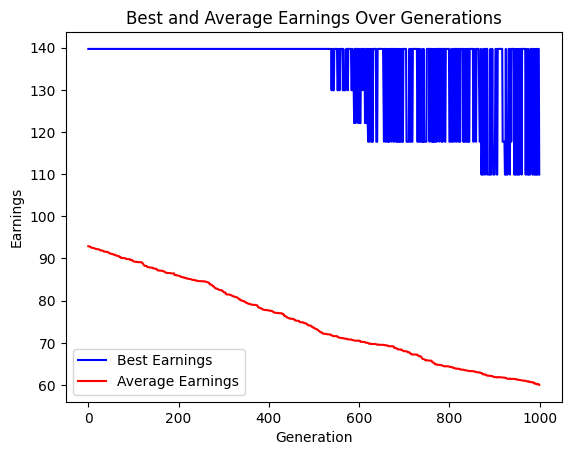

Best params:  [0.750412111967787, -1.3141725942190896, -0.786927836822473, -1.0864433337353518]


In [931]:
requests = []
for index, row in generated_requests.iterrows():
    req = Request(
        start_time=row['start_time'],
        duration=row['duration_mins'],
        distance=row['distance_km'],
        money=row['net_earnings'],
        start_latitude=row['pickup_lat'],
        start_longitude=row['pickup_lon'],
        end_latitude=row['drop_lat'],
        end_longitude=row['drop_lon']
    )
    requests.append(req)

best_params = train(requests, 1000)
print("Best params: ", best_params)